<a href="https://colab.research.google.com/github/OscarRojasG/OCR/blob/main/image%20resizing%20now%20uses%20padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

The dataset contains 26 folders (A-Z) containing handwritten images in size 28x28 pixels, each alphabet in the image is centre fitted to 20x20 pixel box.

Each image is stored as Gray-level

https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format/

## Cargar dataset completo

No recomendable... se agota la RAM de colab y tarda demasiado en cargar.

Se recomienda reducir el volumen del dataset (revisar sección "Exportar").

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("A_Z Handwritten Data.csv", header=None, dtype=np.uint8, nrows=10000)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Cargar muestra

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("sample.csv", dtype=np.uint8, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0,0,0,0,0,0,0,0,0,0,...,0,98,255,233,31,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,77,135,27,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,68,161,101,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,166,183,31,0


In [4]:
from PIL import Image as Img

pixels = df.iloc[0].to_numpy()[1:]
pixels = np.reshape(pixels, (20, 20))

img = Img.fromarray(pixels)
img

In [5]:
from io import BytesIO
from IPython.display import display, Image

def draw_image(pixel_arr, width, height):
    pixels = np.reshape(pixel_arr, (height, width))
    img = Img.fromarray(pixels)

    bio = BytesIO()
    img.save(bio, format='jpeg')
    return display(Image(bio.getvalue(), format='jpeg'))

## Exportar

Funciones para exportar dataset con 1000 filas por clase.

In [ ]:
letters = np.zeros(shape=(26, 1000, 785))

In [ ]:
# Asegurarse que todas las clases tengan 1000 datos como mínimo
df.iloc[:, 0].value_counts()

0     1000
1     1000
24    1000
23    1000
22    1000
21    1000
20    1000
19    1000
18    1000
17    1000
16    1000
15    1000
14    1000
13    1000
12    1000
11    1000
10    1000
9     1000
8     1000
7     1000
6     1000
5     1000
4     1000
3     1000
2     1000
25    1000
Name: 0, dtype: int64

In [ ]:
for letter in range(26):
    arr = df[df.iloc[:, 0] == letter].to_numpy()
    arr = arr[:1000]
    letters[letter] = arr

In [ ]:
flt_arr = letters.reshape(26000, 785)
np.savetxt("sample.csv", flt_arr.astype(int), fmt='%i', delimiter=",")

## Aplicar bounding box a dataset

In [ ]:
out_box_cols = []

for i in range(1, 785):
    x = (i-1) % 28
    y = (i-1) // 28

    # Pixeles fuera del centro de 20x20
    if x < 4 or x > 23 or y < 4 or y > 23:
        out_box_cols.append(i)

In [ ]:
sum = 0

# Casillas no negras fuera del centro
for col in out_box_cols:
    sum += 26000 - df.iloc[:, col].value_counts()[0]

sum

885

Vemos que existe algo de ruido en las imágenes, pero si eliminamos estas casillas no debería afectar mucho...

In [ ]:
# 28x28 - 20x20
len(out_box_cols)

384

In [ ]:
df_box = df.drop(df.columns[out_box_cols], axis=1)

In [ ]:
pixels = df_box.iloc[0].to_numpy()[1:]
pixels = np.reshape(pixels, (20, 20))

img = Img.fromarray(pixels)
img

In [ ]:
df_box_arr = df_box.to_numpy()
np.savetxt("sample.csv", df_box_arr.astype(int), fmt='%i', delimiter=",")

# Modelo

In [6]:
from sklearn.model_selection import train_test_split

Y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

Creación del modelo

In [7]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Dense(100, activation='sigmoid', input_shape=(400,)))
model.add(layers.Dense(26, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamiento

In [8]:
model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
650/650 [==============================] - 2s 2ms/step - loss: 2.0140 - accuracy: 0.4932
Epoch 2/100
650/650 [==============================] - 1s 2ms/step - loss: 1.1013 - accuracy: 0.7166
Epoch 3/100
650/650 [==============================] - 1s 2ms/step - loss: 0.9219 - accuracy: 0.7548
Epoch 4/100
650/650 [==============================] - 1s 2ms/step - loss: 0.8266 - accuracy: 0.7726
Epoch 5/100
650/650 [==============================] - 2s 2ms/step - loss: 0.7699 - accuracy: 0.7862
Epoch 6/100
650/650 [==============================] - 2s 3ms/step - loss: 0.7363 - accuracy: 0.7954
Epoch 7/100
650/650 [==============================] - 1s 2ms/step - loss: 0.7062 - accuracy: 0.7980
Epoch 8/100
650/650 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.8005
Epoch 9/100
650/650 [==============================] - 1s 2ms/step - loss: 0.6794 - accuracy: 0.8045
Epoch 10/100
650/650 [==============================] - 1s 2ms/step - loss: 0.6727 - accura

Validación con datos de prueba: entropía categórica - accuracy

In [9]:
model.evaluate(X_test, Y_test, verbose=False)

[0.4302213788032532, 0.8759615421295166]

In [10]:
def predict(image_arr, verbose=False):
    prob = model.predict(np.array([image_arr]))
    pred = prob.argmax()
    letter = chr(ord('A') + pred)

    if verbose:
        print(letter)
        draw_image(image_arr, 20, 20)

    return letter

In [11]:
for i in range(10):
    letter = predict(X_test[i], verbose=True)

1/1 [==============================] - 0s 78ms/step
S


1/1 [==============================] - 0s 20ms/step
O


1/1 [==============================] - 0s 20ms/step
M


1/1 [==============================] - 0s 20ms/step
A


1/1 [==============================] - 0s 20ms/step
U


1/1 [==============================] - 0s 19ms/step
A


1/1 [==============================] - 0s 20ms/step
S


1/1 [==============================] - 0s 22ms/step
K


1/1 [==============================] - 0s 21ms/step
D


1/1 [==============================] - 0s 19ms/step
G


# Procesamiento de imágenes

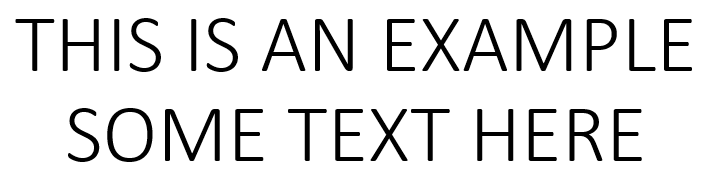

In [25]:
import cv2

img = cv2.imread('example.png')
img.astype("uint8")
Img.fromarray(img)

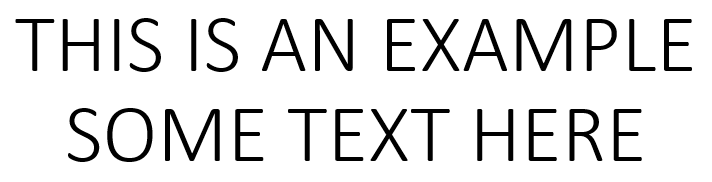

In [26]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Img.fromarray(gray)

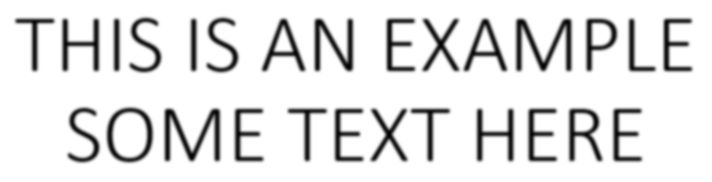

In [27]:
blur = cv2.GaussianBlur(gray, (7,7), 0)
Img.fromarray(blur)

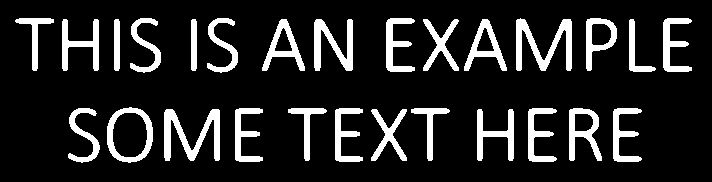

In [29]:
image_contour = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
Img.fromarray(image_contour)

In [ ]:
# Mapa para guardar contornos
contours = dict()

image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
image_dilate = cv2.dilate(image_contour, image_kernel, iterations=5)

# Obtener líneas
lines = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
lines = lines[0]

# Procesar cada línea
for l, line in enumerate(lines):
    contours[l] = dict()
    contours[l]['cntr'] = line
    contours[l]['words'] = dict()

    x, y, w, h = cv2.boundingRect(line)
    line_contour = image_contour[y:y+h, x:x+w]

    line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))
    line_dilate = cv2.dilate(line_contour, line_kernel, iterations=5)

    # Obtener palabras
    words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    words = words[0]

    # Procesar cada palabra
    for w, word in enumerate(words):
        contours[l]['words'][w] = dict()
        contours[l]['words'][w]['cntr'] = word
        contours[l]['words'][w]['letters'] = dict()

        xw, yw, ww, hw = cv2.boundingRect(word)
        word_contour = line_contour[yw:yw+hw, xw:xw+ww]

        # Obtener letras
        letters = cv2.findContours(word_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        letters = letters[0]

        # Guardar cada letra en el mapa
        for c, letter in enumerate(letters):
            contours[l]['words'][w]['letters'][c] = dict()
            contours[l]['words'][w]['letters'][c]['cntr'] = letter

Imagen solo con propósitos ilustrativos...

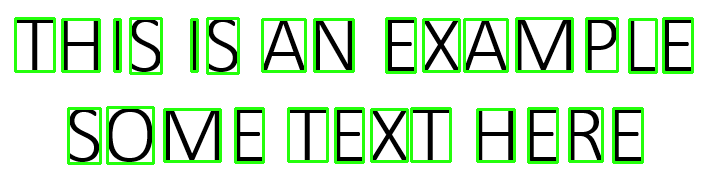

In [ ]:
img2 = img.copy()

for line in contours:
    x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

    for word in contours[line]['words']:
        xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

        for letter in contours[line]['words'][word]['letters']:
            xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])
            cv2.rectangle(img2, (x+xw+xc,y+yw+yc), (x+xw+xc+wc, y+yw+yc+hc), (36,255,12), 2)

Img.fromarray(img2)

Predecir letras en orden

In [ ]:
text = ""

# Ordenar líneas de arriba a abajo
lines = sorted(contours.keys(),
               key=lambda x: cv2.boundingRect(contours[x]['cntr'])[1])

for line in lines:
    # Dimensiones de la línea respecto a la imagen
    x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

    # Ordenar palabras de izquierda a derecha
    words = sorted(contours[line]['words'].keys(),
                   key=lambda x: cv2.boundingRect(contours[line]['words'][x]['cntr'])[0])

    for word in words:
        # Dimensiones de la palabra respecto a la línea
        xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

        # Ordenar letras de izquierda a derecha
        letters = sorted(contours[line]['words'][word]['letters'].keys(),
                         key=lambda x: cv2.boundingRect(contours[line]['words'][word]['letters'][x]['cntr'])[0])

        for letter in letters:
            # Dimensiones de la letra respecto a la palabra
            xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

            # Dimensiones de la letra respecto a la imagen
            letter_img = image_contour[y+yw+yc:y+yw+yc+hc, x+xw+xc:x+xw+xc+wc]

            # Redimensionar letra
            resized = cv2.resize(letter_img, (20,20))

            # Convertir matriz a arreglo
            image_arr = np.ravel(resized)

            # Predecir letra
            letter = predict(image_arr, verbose=True)
            text += letter

        text += " "

    text += "\n"

1/1 [==============================] - 0s 53ms/step
I


1/1 [==============================] - 0s 38ms/step
H


1/1 [==============================] - 0s 54ms/step
B


1/1 [==============================] - 0s 34ms/step
S


1/1 [==============================] - 0s 34ms/step
B


1/1 [==============================] - 0s 22ms/step
S


1/1 [==============================] - 0s 27ms/step
A


1/1 [==============================] - 0s 21ms/step
N


1/1 [==============================] - 0s 24ms/step
E


1/1 [==============================] - 0s 23ms/step
X


1/1 [==============================] - 0s 24ms/step
A


1/1 [==============================] - 0s 30ms/step
V


1/1 [==============================] - 0s 27ms/step
P


1/1 [==============================] - 0s 23ms/step
L


1/1 [==============================] - 0s 22ms/step
E


1/1 [==============================] - 0s 21ms/step
S


1/1 [==============================] - 0s 22ms/step
Q


1/1 [==============================] - 0s 23ms/step
V


1/1 [==============================] - 0s 30ms/step
E


1/1 [==============================] - 0s 22ms/step
T


1/1 [==============================] - 0s 22ms/step
E


1/1 [==============================] - 0s 21ms/step
X


1/1 [==============================] - 0s 24ms/step
T


1/1 [==============================] - 0s 23ms/step
H


1/1 [==============================] - 0s 25ms/step
E


1/1 [==============================] - 0s 26ms/step
R


1/1 [==============================] - 0s 26ms/step
E


In [ ]:
print(text)

IHBS BS AN EXAVPLE 
SQVE TEXT HERE 



# Ejemplos

In [122]:
import cv2
import numpy as np

In [183]:
def preprocessing_image(filename):
    # Leer archivo
    img = cv2.imread(filename)
    img.astype("uint8")

    # Difuminar, pasar a blanco y negro
    preimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    preimg = cv2.threshold(preimg, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    return img, preimg

In [147]:
def get_word_dilation(line_contour):
    # Obtener letras de la línea
    letters = cv2.findContours(line_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    letters = letters[0]

    # Ordenar letras por coordenada X de menor a mayor
    sorted_letters = sorted(letters, key=lambda x: cv2.boundingRect(x)[0])

    # Obtener distancia entre letras consecutivas
    d = []
    for i in range(len(letters)-1):
        x1, y1, w1, h1 = cv2.boundingRect(sorted_letters[i])
        x2, y2, w2, h2 = cv2.boundingRect(sorted_letters[i+1])
        d.append(x2-(x1+w1))

    d = np.array(d).reshape(-1, 1)

    # Separar distancia en 2 grupos: distancias cortas (letras) y largas (palabras)
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    kmeans.fit(d)

    centroids = kmeans.cluster_centers_
    min_centroid = np.argmin(centroids)

    letter_distances = d[kmeans.labels_ == min_centroid]
    letter_distances = letter_distances.ravel()

    # Usar distancia máxima entre letras para calcular dilatación óptima
    max_letter_distance = max(letter_distances)
    optimal_dilation = max_letter_distance + 1
    return optimal_dilation


def get_contours(image_contour):
    # Mapa para guardar contornos
    contours = dict()

    image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (image_contour.shape[1], 1))
    image_dilate = cv2.dilate(image_contour, image_kernel, iterations=5)

    # Obtener líneas
    lines = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lines = lines[0]

    # Procesar cada línea
    for l, line in enumerate(lines):
        contours[l] = dict()
        contours[l]['cntr'] = line
        contours[l]['words'] = dict()

        x, y, w, h = cv2.boundingRect(line)
        line_contour = image_contour[y:y+h, x:x+w]

        word_dilation = get_word_dilation(line_contour)
        line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (word_dilation, 1))
        line_dilate = cv2.dilate(line_contour, line_kernel, iterations=1)

        # Obtener palabras
        words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        words = words[0]

        # Procesar cada palabra
        for w, word in enumerate(words):
            contours[l]['words'][w] = dict()
            contours[l]['words'][w]['cntr'] = word
            contours[l]['words'][w]['letters'] = dict()

            xw, yw, ww, hw = cv2.boundingRect(word)
            word_contour = line_contour[yw:yw+hw, xw:xw+ww]

            # Obtener letras
            letters = cv2.findContours(word_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            letters = letters[0]

            # Guardar cada letra en el mapa
            for c, letter in enumerate(letters):
                contours[l]['words'][w]['letters'][c] = dict()
                contours[l]['words'][w]['letters'][c]['cntr'] = letter

    return contours

In [247]:
def model_predict(image_arr):
    prob = model.predict(np.array([image_arr]), verbose=0)
    pred = prob.argmax()
    letter = chr(ord('A') + pred)

    return letter

def resize_image(image):
    height, width = image.shape
    ratio = height/width

    left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0

    if ratio > 2:
        pad = int(height/2) - width
        left_pad = pad//2
        right_pad = pad//2 + pad%2

    if ratio < 0.5:
        pad = int(width/2) - height
        top_pad = pad//2
        bottom_pad = pad//2 + pad%2

    padding = cv2.copyMakeBorder(image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT)
    resized = cv2.resize(padding, (20,20))
    return resized

def predict_text(image, contours):
    text = ""

    # Ordenar líneas de arriba a abajo
    lines = sorted(contours.keys(),
                key=lambda x: cv2.boundingRect(contours[x]['cntr'])[1])

    for line in lines:
        # Dimensiones de la línea respecto a la imagen
        x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

        # Ordenar palabras de izquierda a derecha
        words = sorted(contours[line]['words'].keys(),
                    key=lambda x: cv2.boundingRect(contours[line]['words'][x]['cntr'])[0])

        for word in words:
            # Dimensiones de la palabra respecto a la línea
            xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

            # Ordenar letras de izquierda a derecha
            letters = sorted(contours[line]['words'][word]['letters'].keys(),
                            key=lambda x: cv2.boundingRect(contours[line]['words'][word]['letters'][x]['cntr'])[0])

            for letter in letters:
                # Dimensiones de la letra respecto a la palabra
                xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

                # Dimensiones de la letra respecto a la imagen
                letter_img = image[y+yw+yc:y+yw+yc+hc, x+xw+xc:x+xw+xc+wc]

                # Redimensionar letra
                resized = resize_image(letter_img)

                # Convertir matriz a arreglo
                image_arr = np.ravel(resized)

                # Predecir letra
                letter = model_predict(image_arr)
                text += letter

            text += " "

        text += "\n"

    return text

In [127]:
from io import BytesIO
from IPython.display import display, Image

def show_image(image):
    img = Img.fromarray(image)
    bio = BytesIO()
    img.save(bio, format='jpeg')
    return display(Image(bio.getvalue(), format='jpeg'))

In [131]:
def draw_contours(image, contours):
    img_lines = image.copy()
    img_words = image.copy()
    img_letters = image.copy()

    for line in contours.keys():
        # Dimensiones de la línea respecto a la imagen
        x, y, w, h = cv2.boundingRect(contours[line]['cntr'])

        # Dibujar linea
        cv2.rectangle(img_lines, (x,y), (x+w, y+h), (36,12,255), 2)

        for word in contours[line]['words'].keys():
            # Dimensiones de la palabra respecto a la línea
            xw, yw, ww, hw = cv2.boundingRect(contours[line]['words'][word]['cntr'])

            # Dibujar palabra
            cv2.rectangle(img_words, (x+xw,y+yw), (x+xw+ww, y+yw+hw), (255,36,12), 2)

            for letter in contours[line]['words'][word]['letters'].keys():
                # Dimensiones de la letra respecto a la palabra
                xc, yc, wc, hc = cv2.boundingRect(contours[line]['words'][word]['letters'][letter]['cntr'])

                cv2.rectangle(img_letters, (x+xw+xc,y+yw+yc), (x+xw+xc+wc, y+yw+yc+hc), (36,255,12), 2)

    show_image(img_lines)
    show_image(img_words)
    show_image(img_letters)

In [138]:
def get_text(filename, verbose=False):
    img, preimg = preprocessing_image(filename)
    contours = get_contours(preimg)
    if verbose: draw_contours(img, contours)
    text = predict_text(preimg, contours)

    return text

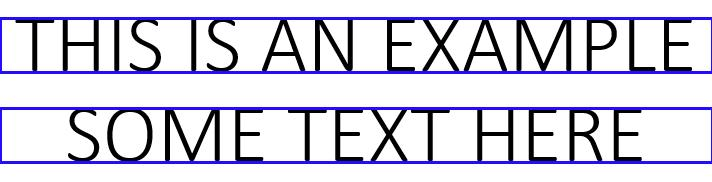

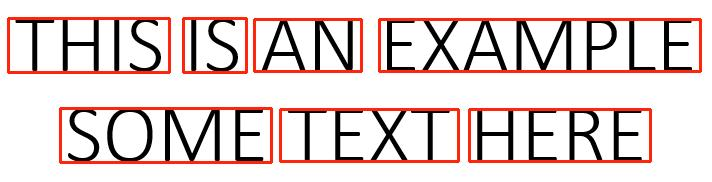

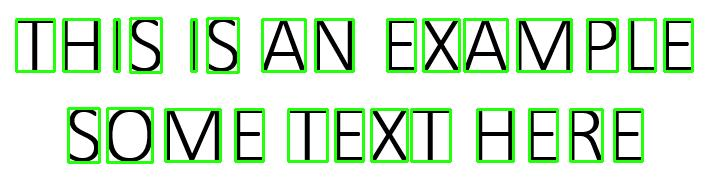

THIS IS AH FXAVFKF 
SBVF TFXT HFRF 



In [248]:
text = get_text("example.png", True)
print(text)

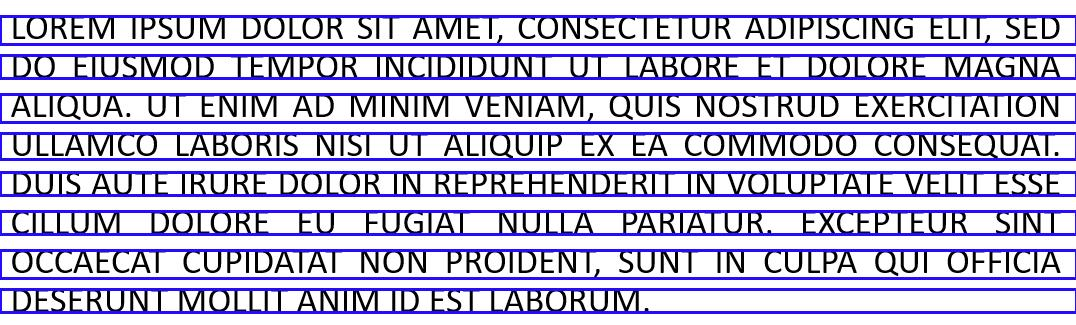

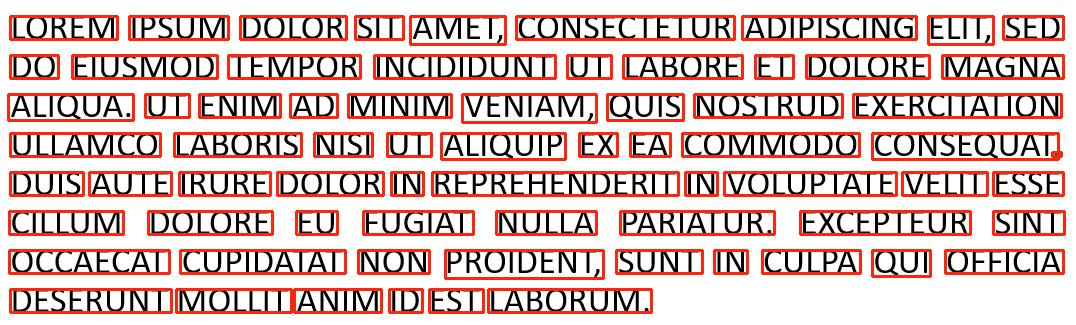

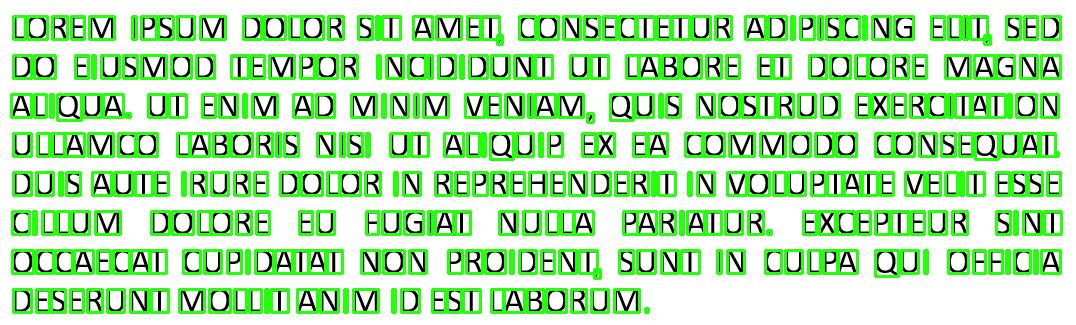

KOREV GPSUV DOKOR SGT AVETA COHSECTETUR ADGPGSCGHG EKGTB SED 
DO EGUSVOD TEHPOR GHCGDGDUHT UT KABORE ET DOKORE NAGHA 
AKGQUAB UT EHGH AD VGHGN VEHGANB QUGS HOSTRUD EXERCGIAIGOH 
UKKAVCO KABORGS HGSG UT AKGQUGP EX EA COVVODO COHSEQUAIB B 
DUGS AUTE GRURE DOKOR GH REPREHEHDERGT GH VOKUPIAIE VELGT ESSE 
CGKKUH DOKORE EU FUGGAI HUKKA PARGAIURB EXCEPTEUR SGHT 
OCCAECAI CUPGDAIAI HOH PROGDEHIP SUHT GH CULPA QUG OFFGCGA 
DESERUHT NOKKGT AHGV GD EST LABORUVB 



In [242]:
text = get_text("image.png", True)
print(text)

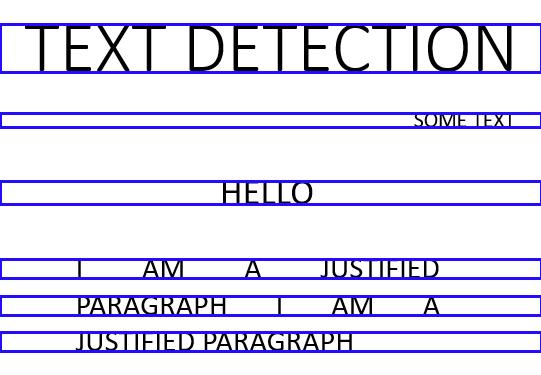

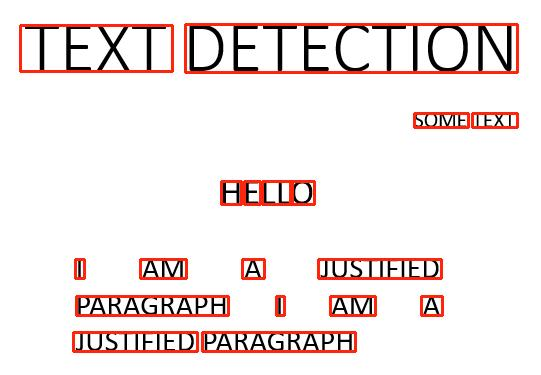

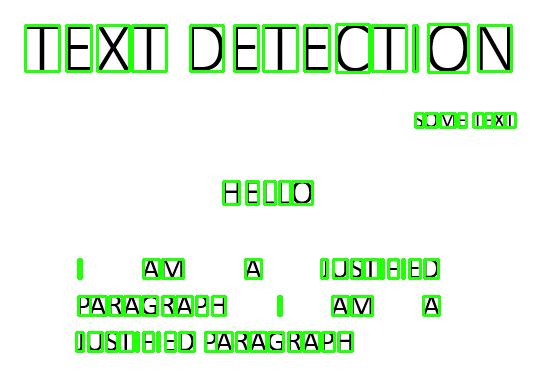

TFXT BFTFCTBOH 
BQVF TFXI 
H F KL O 
B AV A JUBIBFBEB 
PARAGRAFH B AV A 
JUSTBFBFD FARAGRAPH 



In [184]:
text = get_text("example2.png", True)
print(text)

# Experimentos

Relación dilatación (horizontal) y bounding box ;)

In [93]:
import cv2

def get_dilation_variation(filename, iterations=10):
    left_var = []
    right_var = []

    img = cv2.imread('example.png')
    img.astype("uint8")
    Img.fromarray(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    Img.fromarray(gray)

    blur = cv2.GaussianBlur(gray, (7,7), 0)
    Img.fromarray(blur)

    image_contour = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    Img.fromarray(image_contour)

    words = cv2.findContours(image_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    words = words[0]
    x, y, w, h = cv2.boundingRect(words[0])

    for dilation in range(1, iterations+1):
        image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilation, 1))
        image_dilate = cv2.dilate(image_contour, image_kernel, iterations=1)
        Img.fromarray(image_dilate)

        words = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        words = words[0]

        xd, yd, wd, hd = cv2.boundingRect(words[0])
        left_var.append(x-xd)
        right_var.append(xd+wd-x-w)

    return left_var, right_var

In [94]:
get_dilation_variation("example.png")

([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

In [95]:
get_dilation_variation("image.png")

([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

In [96]:
get_dilation_variation("hello.png")

([0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 1, 2, 2, 3, 3, 4, 4, 5])

La dilatación es independiente del tamaño de la imagen!

Según el experimento, una dilatación $X$ ensancha la imagen $(X-1)/2$ pixeles a cada lado (izquierda y derecha).

A partir de esto, podemos calcular la separación óptima entre palabras de una línea con el siguiente algoritmo:

1. Calcular las coordenadas de las letras.

2. Ordenar letras por coordenada $x$ de menor a mayor.

3. Calcular la distancia entre letras consecutivas y guardarlas en un arreglo $D$.

4. Agrupar las distancias en dos clústeres $D_1$ y $D_2$

5. Utilizar distancia $\max(D_1)$ para calcular la dilatación mínima necesaria para separar cada palabra...

La dilatación mínima para rellenar la distancia $\max(D_1)$ es $X = \max(D_1)+1$


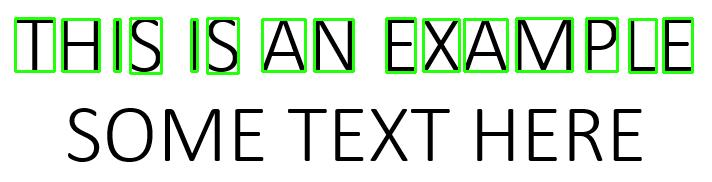

[8, 15, 10, 30, 10, 24, 9, 33, 8, 5, 9, 14, 12, 7]


In [140]:
img = cv2.imread('example.png')
img.astype("uint8")
Img.fromarray(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Img.fromarray(gray)

blur = cv2.GaussianBlur(gray, (7,7), 0)
Img.fromarray(blur)

image_contour = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
Img.fromarray(image_contour)

# Paso 0: obtener líneas
image_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
image_dilate = cv2.dilate(image_contour, image_kernel, iterations=5)

lines = cv2.findContours(image_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
line = lines[0][1] # Trabajaremos solo con línea 0 por simplicidad...

x, y, w, h = cv2.boundingRect(line)
line_contour = image_contour[y:y+h, x:x+w]

# Paso 1
letters = cv2.findContours(line_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
letters = letters[0]

img2 = img.copy()
for letter in letters:
    xc, yc, wc, hc = cv2.boundingRect(letter)
    cv2.rectangle(img2, (x+xc,y+yc), (x+xc+wc, y+yc+hc), (36,255,12), 2)

show_image(img2)

# Paso 2
sorted_letters = sorted(letters, key=lambda x: cv2.boundingRect(x)[0])

# Paso 3
d = []
for i in range(len(letters)-1):
    x1, y1, w1, h1 = cv2.boundingRect(sorted_letters[i])
    x2, y2, w2, h2 = cv2.boundingRect(sorted_letters[i+1])
    d.append(x2-(x1+w1))

print(d)

In [141]:
import numpy as np
from sklearn.cluster import KMeans

# Paso 4
d = np.array(d).reshape(-1, 1)

kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(d)

centroids = kmeans.cluster_centers_
min_centroid = np.argmin(centroids)

letter_distances = d[kmeans.labels_ == min_centroid]
letter_distances = letter_distances.ravel()
print("Separaciones letras:", letter_distances)

word_distances = d[kmeans.labels_ == (1 - min_centroid)]
word_distances = word_distances.ravel()
print("Separaciones palabras:", word_distances)

Separaciones letras: [ 8 15 10 10  9  8  5  9 14 12  7]
Separaciones palabras: [30 24 33]


In [119]:
# Paso 5
max_letter_distance = max(letter_distances)
optimal_dilation = max_letter_distance + 1
optimal_dilation

16

Veamos... :)

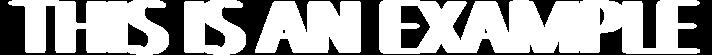

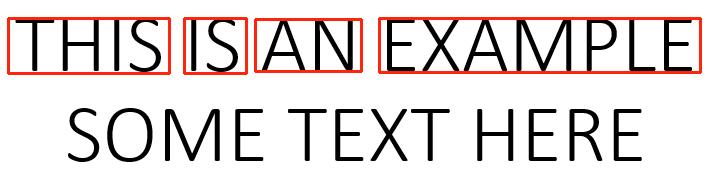

In [120]:
x, y, w, h = cv2.boundingRect(line)
line_contour = image_contour[y:y+h, x:x+w]

line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (optimal_dilation, 1))
line_dilate = cv2.dilate(line_contour, line_kernel, iterations=1)

show_image(line_dilate)

# Paso 1
words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
words = words[0]

img2 = img.copy()
for word in words:
    xw, yw, ww, hw = cv2.boundingRect(word)
    cv2.rectangle(img2, (x+xw,y+yw), (x+xw+ww, y+yw+hw), (255,36,12), 2)

show_image(img2)

Perfecto... y si restamos 1 a la dilatación "óptima"?

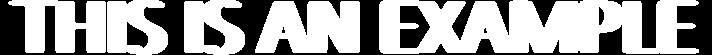

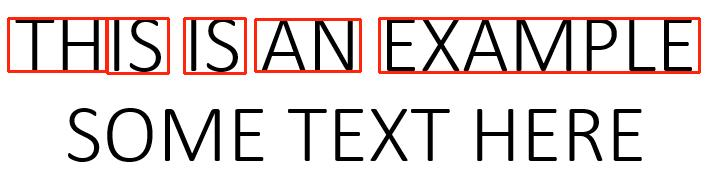

In [121]:
x, y, w, h = cv2.boundingRect(line)
line_contour = image_contour[y:y+h, x:x+w]

line_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (optimal_dilation-1, 1))
line_dilate = cv2.dilate(line_contour, line_kernel, iterations=1)

show_image(line_dilate)

# Paso 1
words = cv2.findContours(line_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
words = words[0]

img2 = img.copy()
for word in words:
    xw, yw, ww, hw = cv2.boundingRect(word)
    cv2.rectangle(img2, (x+xw,y+yw), (x+xw+ww, y+yw+hw), (255,36,12), 2)

show_image(img2)

Hay 2 contornos en la primera palabra, por lo tanto no nos sirve ;)

# Entorno para experimentos

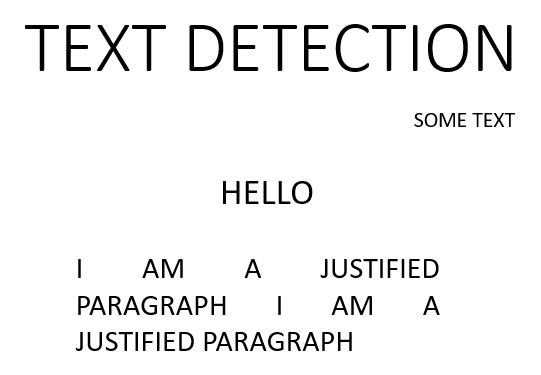

In [165]:
import cv2

img = cv2.imread('example2.png')
img.astype("uint8")
Img.fromarray(img)

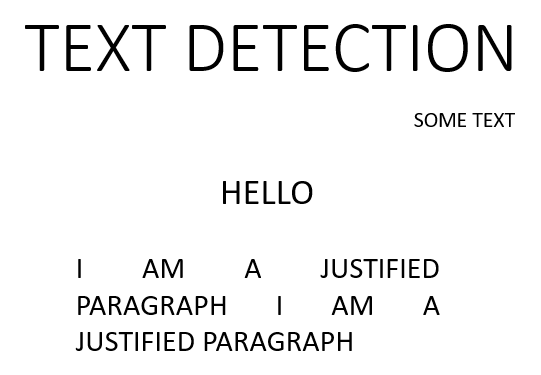

In [166]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Img.fromarray(gray)

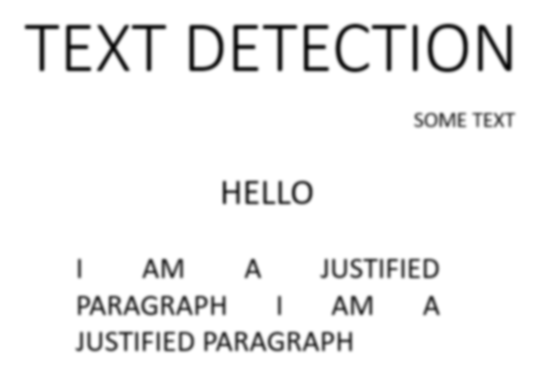

In [167]:
blur = cv2.GaussianBlur(gray, (7,7), 0)
Img.fromarray(blur)

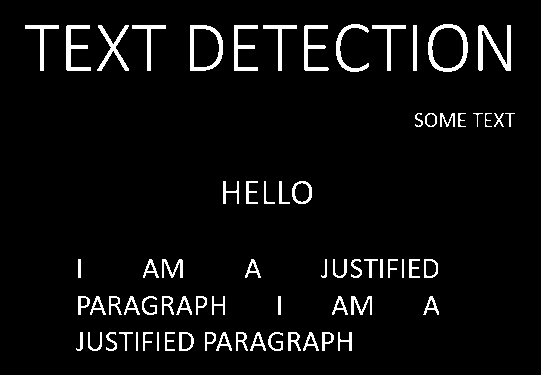

In [180]:
image_contour = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
Img.fromarray(image_contour)

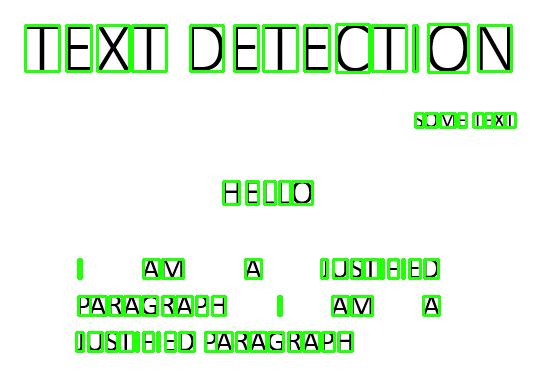

In [182]:
# Obtener letras
letters = cv2.findContours(image_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
letters = letters[0]

img2 = img.copy()
for letter in letters:
    x, y, w, h = cv2.boundingRect(letter)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (36,255,12), 2)

show_image(img2)

In [237]:
letter = letters[11]

x, y, w, h = cv2.boundingRect(letter)
letter_img = image_contour[y:y+h, x:x+w]

show_image(letter_img)

In [238]:
resized = cv2.resize(letter_img, (20,20))
show_image(resized)

In [239]:
height, width = letter_img.shape
ratio = height/width

left_pad, right_pad, top_pad, bottom_pad = 0, 0, 0, 0

if ratio > 2:
    pad = int(height/2) - width
    left_pad = pad//2
    right_pad = pad//2 + pad%2

if ratio < 0.5:
    pad = int(width/2) - height
    top_pad = pad//2
    bottom_pad = pad//2 + pad%2

padding = cv2.copyMakeBorder(letter_img, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT)
resized = cv2.resize(padding, (20,20))
show_image(resized)